## Данные
Данные были собраны из открытого источника Common Voice [Link](https://commonvoice.mozilla.org/ru/datasets).

|         | ru  | en  | de  |
| ------- | --- | --- | --- |
| version | v6  | v1  | v1  |
| GB      | 3   | 21  | 4   |
| format  | mp3 | mp3 | mp3 |
| hours   | 111 | 582 | 140 |

Заметки:
- В данных довольно часто попадают зашумленые аудио сэмплы, особенно в немецком датасете.
- Часто бывает что речь может начаться спустя 2-3 секунды в записях.
- Попадаются записи без речи даже в провалидированных выборках.
- Имеются мужские и женский голоса разных возрастов.

In [44]:
%matplotlib inline
from importlib import reload
import IPython.display as ipd
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import librosa
import librosa.display
import sys, os
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

from lid import datautil
data_store = "/Users/a18180846/projects/data"

In [19]:
# Load preprocessed data less 10 seconds
df = pd.read_csv("../data/preprocessed_valid.csv")
df['mp3'] = df.apply(lambda row: os.path.join(data_store, row.label, 'clips', row.path.replace('.npy', '.mp3')), axis=1)
print(df.shape)
print(df.label.value_counts())
df.head()


(349229, 4)
de    132819
en    129287
ru     87123
Name: label, dtype: int64


,path,label,duration_ms,mp3
0,common_voice_ru_18923277.npy,ru,6660,/Users/a18180846/projects/data/ru/clips/common...
1,common_voice_ru_19517100.npy,ru,4170,/Users/a18180846/projects/data/ru/clips/common...
2,common_voice_ru_19027546.npy,ru,6390,/Users/a18180846/projects/data/ru/clips/common...
3,common_voice_ru_22728593.npy,ru,5010,/Users/a18180846/projects/data/ru/clips/common...
4,common_voice_ru_19103382.npy,ru,4650,/Users/a18180846/projects/data/ru/clips/common...


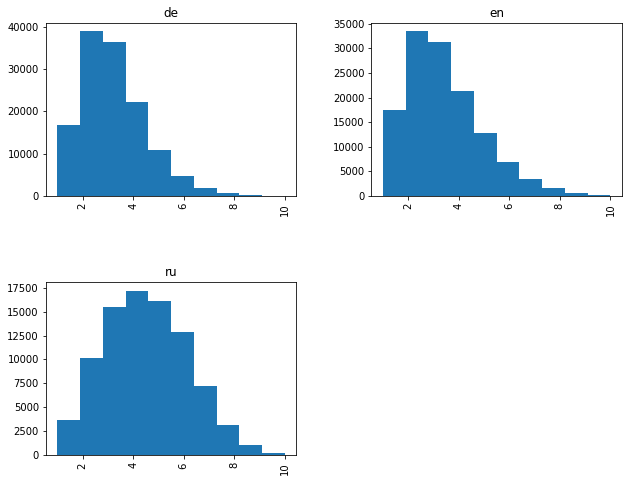

In [20]:
(df.duration_ms // 1000).hist(by=df.label, figsize=(10,8))
plt.title("Duration in seconds")
plt.show()

In [41]:
def audio_sample(lang, N=2):
    """ru, en, de"""
    
    for path in df[df.label == lang].mp3.sample(N):
        audio_widget = ipd.Audio(path)
        ipd.display(audio_widget)
        #plot_spectrogram(path, figsize=(8, 4))
print("Russian")
audio_sample('ru')
print("English")
audio_sample('en')
print("Dutch")
audio_sample('de')

Russian


English


Dutch


## One file anlysis

In [43]:
audio_widget = ipd.Audio(df.iloc[0].mp3)
ipd.display(audio_widget)

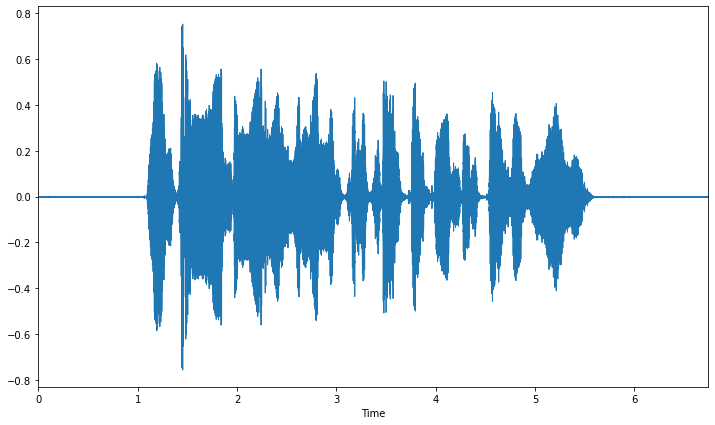

In [45]:
def plot_waveform(f, out=None, figsize=(12,7), scale='db'):
    y, sr = librosa.load(f, sr=44100)
    
    fig, ax = plt.subplots(1, figsize=figsize)

    if scale == 'db':
        a = librosa.core.amplitude_to_db(y)
    elif scale == 'linear':
        a = y
    else:
        raise ValueError('Unknown scale {}'.format(scale))
    
    librosa.display.waveplot(a, ax=ax, x_axis='time', sr=sr)
    
    if out:
        fig.savefig(out, bbox_inches='tight', pad_inches=0)
    return fig


plot_waveform(df.iloc[0].mp3, scale='linear');

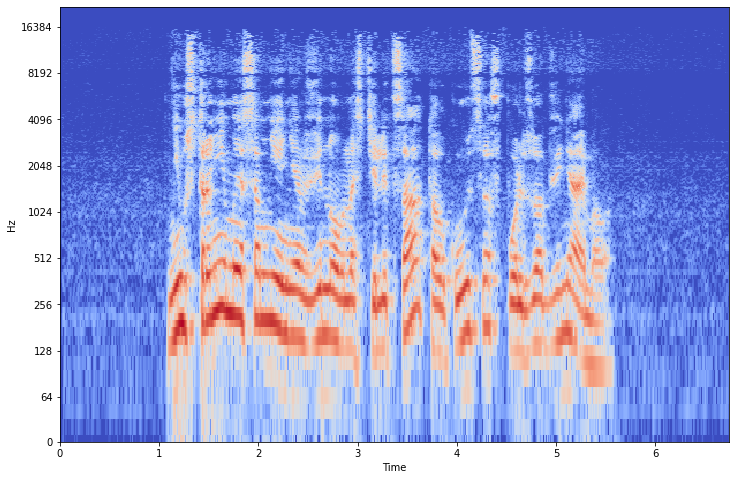

In [52]:
def plot_spectrogram(f, cmap=None):
    y, sr = librosa.load(f, sr=44100)

    S = np.abs(librosa.stft(y))
    S = librosa.amplitude_to_db(S, ref=np.max)

    kwargs = dict(
        y_axis='log', x_axis='time', sr=sr,
    )
    if cmap is not None:
        kwargs['cmap'] = cmap
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(S, **kwargs)
    


plot_spectrogram(df.iloc[0].mp3, cmap='coolwarm')

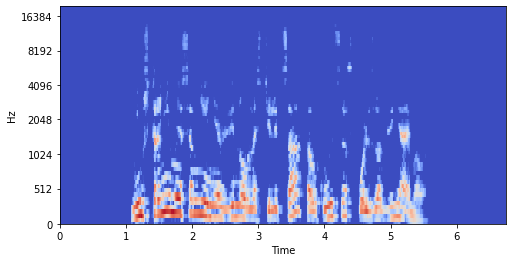

In [60]:
import scipy.ndimage

def plot_melspectrogram(f, figsize=(8,4), meansubtract=False, medianfilter=None, fmin=0):
    y, sr = librosa.load(f, sr=44100)
    
    fig, ax = plt.subplots(1, figsize=figsize)

    S = librosa.stft(y)
    mels = librosa.feature.melspectrogram(y=y, sr=sr, fmin=fmin, fmax=20000, n_mels=64)
    #mels = librosa.feature.melspectrogram(S=S, sr=sr, fmin=fmin, fmax=20000, n_mels=64)
    S = librosa.amplitude_to_db(mels, ref=np.max)
    if meansubtract:
        S = S - (np.mean(S) + 1e-8)
    if medianfilter:
        S = scipy.ndimage.median_filter(S, medianfilter)

    librosa.display.specshow(S, ax=ax, y_axis='mel', x_axis='time', fmin=fmin, fmax=20000, sr=sr)


plot_melspectrogram(df.iloc[0].mp3, meansubtract=True, medianfilter=None);